# w261 Final Project - Clickthrough Rate Prediction


Team 24   
Vivian Lu, Siddhartha Jakkamreddy, Venky Nagapudi, Luca Garre   
Summer 2019, sections 4 and 5   

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

## __Introduction__
Online ad is a multibillion dollar industry fueled by large investments and ever increasing performance goals. Targeted advertisement based on users' browsing industry and demographic, ad features such as overall appearance, employed colors and text, and website features such as ad's relative placement in the webpage, sizes, etc., is receiving more and more interest due to its potential for revenue generation. In this context, machine learning is proving resourceful in the understanding of the features that mostly affect users' Click-Through Rates (CTR) and, based on this understanding, in informing the design of ads that maximize performance metrics such as click and convertion rates. Further, machine learning solutions can easily be deployed in a data pipeline enviroment in order to select and offer, on a user-specific basis, the ad which expectedly maximizes the user's interest. 

...

## __Goal of the analysis__
The purpose of the present analysis is to estimate whether a given ad will be clicked based on a set of features describing the ad. 

...

## __Description of the dataset__
The dataset is provided by [put_reference_to_CriteoLabs] and is composed of three files, a `readme.txt`, a `train.txt` and a `test.txt` file, respectively. The readme file contains a brief description of the data. The `train.txt` and `test.txt` files contain the train and test data. Both files are formatted as tab separated value tables, and amount to 45840617 and 6042135 rows for the train and test data, respectively. Following the description of the data, each row represents an ad and contains the following fields (see commands below, these expect the data to be contained in a data folder inside the current working directory):

- 1 binary field indicating whether the ad has been clicked (1) or not (0). This field is available only for the train data;
- 13 fields containing integer features representing counts;
- 26 categorical features. These are hashed as 32 bits keys for anonymization purposes;

From a printout of the first rows of the data files it appears that the data contain no headers. This implies that, with the sole exception of the first binary field, it is not possible to characterize the various fields in terms of the features these represent. It is also noted that rows in the data can have missing values. This is again noticed when looking at the printed lines, as these have a number of entries which is lower than the number of fields specified in the `readme.txt` file. 

...

In [5]:
#number of rows in the train data
!wc -l data/train.txt

45840617 data/train.txt


In [6]:
#number of rows in the test data
!wc -l data/test.txt

6042135 data/test.txt


In [7]:
# first row of the train data
!head -1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [8]:
# first row of the test data
!head -1 data/test.txt

	29	50	5	7260	437	1	4	14		1	0	6	5a9ed9b0	a0e12995	a1e14474	08a40877	25c83c98		964d1fdd	5b392875	a73ee510	de89c3d2	59cd5ae7	8d98db20	8b216f7b	1adce6ef	78c64a1d	3ecdadf7	3486227d	1616f155	21ddcdc9	5840adea	2c277e62		423fab69	54c91918	9b3e8820	e75c9ae9


# __Section 2__ - Algorithm Explanation

# __Section 3__ - EDA & Challenges

# __Section 4__ - Algorithm Implementation

# __Section 5__ - Course Concepts

In [24]:
# imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
plt.style.use('seaborn')
import time

In [16]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [17]:
PWD

'/media/notebooks/W261_Final_Project'

In [18]:
# create Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
# create a random sample from train data for EDA (20%)
# fixed seed for reproduceability 
train_sample = sc.textFile('data/train.txt').sample(False,0.05,2019).cache()

In [6]:
train_sample.top(5)

['1\t99\t9\t35\t30\t1\t11\t154\t27\t44\t1\t8\t\t11\t05db9164\t89ddfee8\td08c8f30\t3805af8d\t25c83c98\t7e0ccccf\t1c86e0eb\t062b5529\ta73ee510\t935a36f0\t755e4a50\tadd8347b\t5978055e\t051219e6\td5223973\tf8a48751\te5ba7672\t5bb2ec8e\t21ddcdc9\ta458ea53\t540e0e34\t\t32c7478e\t3fdb382b\tf0f449dd\t49d68486',
 '1\t99\t44\t2\t2\t1153\t2\t2959\t17\t265\t2\t50\t1\t2\t5a9ed9b0\t26a88120\tb00d1501\td16679b9\t25c83c98\t7e0ccccf\t3f4ec687\t5b392875\ta73ee510\t0e9ead52\tc4adf918\te0d76380\t85dbe138\tb28479f6\t2ebbf26a\t1203a270\t8efede7f\tb486119d\t\t\t73d06dde\tad3062eb\t32c7478e\taee52b6f\t\t',
 '1\t99\t38\t1\t3\t10\t4\t374\t23\t426\t1\t19\t42\t3\t68fd1e64\t26a88120\td032c263\tc18be181\t0942e0a7\tfbad5c96\t3f4ec687\t1f89b562\ta73ee510\t726f00fd\tc4adf918\tdfbb09fb\t85dbe138\t07d13a8f\t040ec437\t84898b2a\t8efede7f\t57598e25\t\t\t0014c32a\t\t32c7478e\t3b183c5c\t\t',
 '1\t99\t33\t2\t2\t433\t32\t166\t30\t129\t1\t5\t\t2\t05db9164\t9e5ce894\t3e90a31f\t13508380\t25c83c98\t7e0ccccf\t3598a741\t0b153874\ta7

In [7]:
train_sample.coalesce(1,True).saveAsTextFile("train_sample.txt")

In [8]:
!head -5 train_sample.txt/part-00000

0	0	1		0	16597	557	3	5	123	0	1		1	8cf07265	7cd19acc	77f2f2e5	d16679b9	4cf72387	fbad5c96	8fb24933	0b153874	a73ee510	0095a535	3617b5f5	9f32b866	428332cf	b28479f6	83ebd498	31ca40b6	e5ba7672	d0e5eb07			dfcfc3fa	ad3062eb	32c7478e	aee52b6f		
0	1	0	1		1427	3	16	11	50	0	2	1		05db9164	26a88120	615e3e4e	2788fed8	4cf72387	7e0ccccf	3f4ec687	0b153874	a73ee510	0e9ead52	c4adf918	f5d19c1c	85dbe138	07d13a8f	24ff9452	1034ac0d	3486227d	b486119d			63580fba		32c7478e	2a90c749		
0		1			23255		0	1	73		0			7e5c2ff4	d833535f	b00d1501	d16679b9	25c83c98	7e0ccccf	65c53f25	1f89b562	a73ee510	3b08e48b	ad2bc6f4	e0d76380	39ccb769	b28479f6	a733d362	1203a270	776ce399	281769c2			73d06dde		32c7478e	aee52b6f		
0	0	37	23	9	1635	84	2	17	109	0	2		50	05db9164	9b25e48b	2d9b2559	96302ef8	43b19349	fbad5c96	e64ca89e	5b392875	a73ee510	3b76bfa9	87bb382c	3d899a5a	d95a2a6d	8ceecbc8	8f3ef960	24352c5c	07c540c4	7d8c03aa	fbf39fb5	a458ea53	0c61029b		32c7478e	216a829e	001f3601	abc00283
0	2	0	9	5	44	5	2	4	5	2	2		5	5a9ed9b0	3e4b7926	e1266b28	

In [13]:
df = pd.read_csv('train_sample.txt/part-00000', delimiter='\t', header=None)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0,0.0,1,NaN,0.0,16597.0,557.0,3.0,5.0,123.0,...,e5ba7672,d0e5eb07,NaN,NaN,dfcfc3fa,ad3062eb,32c7478e,aee52b6f,NaN,NaN
1,0,1.0,0,1.0,NaN,1427.0,3.0,16.0,11.0,50.0,...,3486227d,b486119d,NaN,NaN,63580fba,NaN,32c7478e,2a90c749,NaN,NaN
2,0,NaN,1,NaN,NaN,23255.0,NaN,0.0,1.0,73.0,...,776ce399,281769c2,NaN,NaN,73d06dde,NaN,32c7478e,aee52b6f,NaN,NaN
3,0,0.0,37,23.0,9.0,1635.0,84.0,2.0,17.0,109.0,...,07c540c4,7d8c03aa,fbf39fb5,a458ea53,0c61029b,NaN,32c7478e,216a829e,001f3601,abc00283
4,0,2.0,0,9.0,5.0,44.0,5.0,2.0,4.0,5.0,...,07c540c4,e261f8d8,21ddcdc9,b1252a9d,31b4af04,NaN,32c7478e,8d653a3e,445bbe3b,32280082


In [7]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,2.292037e+06,1.253362e+06,2.292037e+06,1.799718e+06,1.794652e+06,2.232828e+06,1.779597e+06,2.193136e+06,2.290882e+06,2.193136e+06,1.253362e+06,2.193136e+06,537580.000000,1.794652e+06
mean,2.564675e-01,3.524587e+00,1.055237e+02,2.703023e+01,7.327119e+00,1.853603e+04,1.155878e+02,1.645949e+01,1.253695e+01,1.059942e+02,6.180864e-01,2.738067e+00,0.992498,8.217248e+00
std,4.366830e-01,9.456074e+00,3.879461e+02,4.026174e+02,8.845165e+00,6.915318e+04,3.370288e+02,7.080816e+01,1.692911e+01,2.197440e+02,6.845344e-01,5.228751e+00,6.083341,1.587631e+01
min,0.000000e+00,0.000000e+00,-2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.260000e+02,8.000000e+00,1.000000e+00,2.000000e+00,1.000000e+01,0.000000e+00,1.000000e+00,0.000000,2.000000e+00
50%,0.000000e+00,1.000000e+00,3.000000e+00,6.000000e+00,4.000000e+00,2.812000e+03,3.200000e+01,3.000000e+00,7.000000e+00,3.800000e+01,1.000000e+00,1.000000e+00,0.000000,4.000000e+00
75%,1.000000e+00,3.000000e+00,3.500000e+01,1.800000e+01,1.000000e+01,1.013600e+04,1.020000e+02,1.100000e+01,1.900000e+01,1.100000e+02,1.000000e+00,3.000000e+00,1.000000,1.000000e+01
max,1.000000e+00,1.575000e+03,1.921900e+04,6.553500e+04,9.690000e+02,2.634953e+06,6.661900e+04,3.453600e+04,4.513000e+03,1.834500e+04,8.000000e+00,1.630000e+02,1831.000000,4.317000e+03


In [8]:
df.columns = ['c0','c1', 'c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13','c14','c15','c16','c17','c18','c19','c20','c21','c22','c23','c24','c25','c26','c27','c28','c29','c30','c31','c32','c33','c34','c35','c36','c37','c38','c39']

(array([1704204.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  587833.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

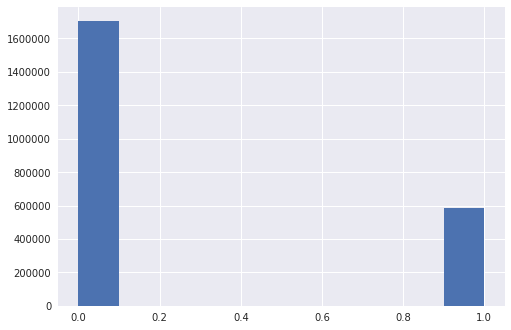

In [9]:
plt.hist(df['c0'])

In [16]:
# part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
df[df[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

ValueError: Must pass DataFrame with boolean values only

KeyboardInterrupt: 

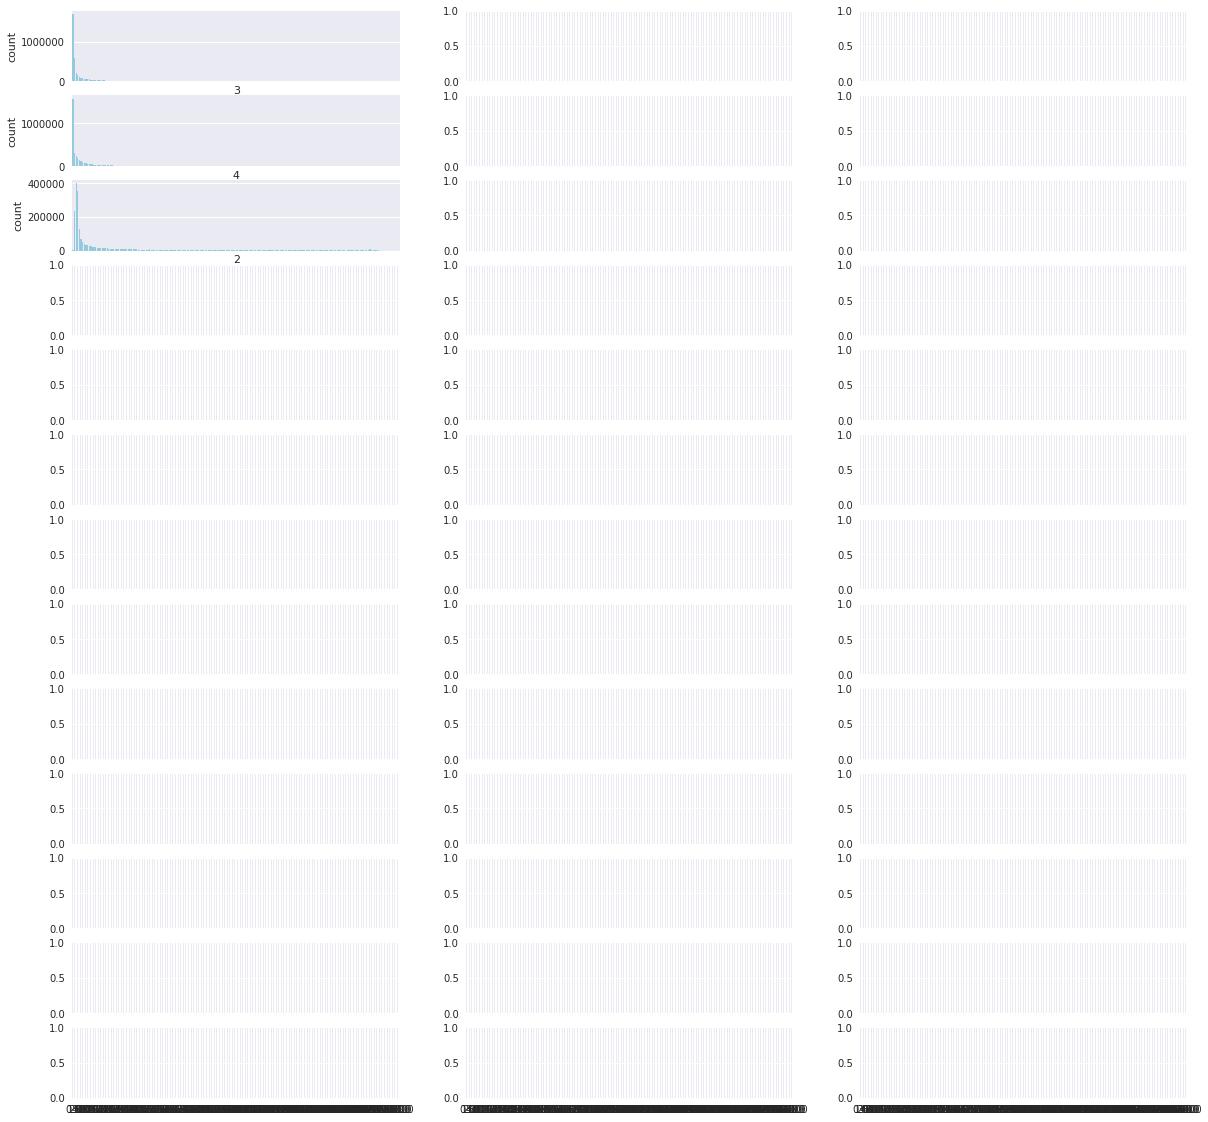

In [17]:
f, axes = plt.subplots(13, 3, figsize=(20, 20), sharex=True)
for i, feature in enumerate(df.columns):
    sns.countplot(df[feature].fillna(0) , color="skyblue", ax=axes[i%3, i//13])

In [ ]:
for k, v in df.nunique().to_dict().items():
    print('{}={}'.format(k,v))

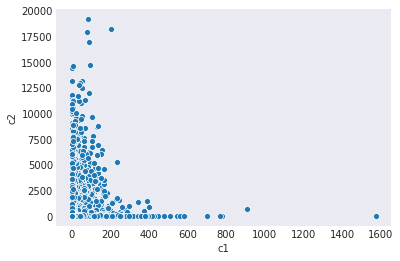

In [21]:
sns.scatterplot(x=df['c1'],y=df['c2'],data=df)

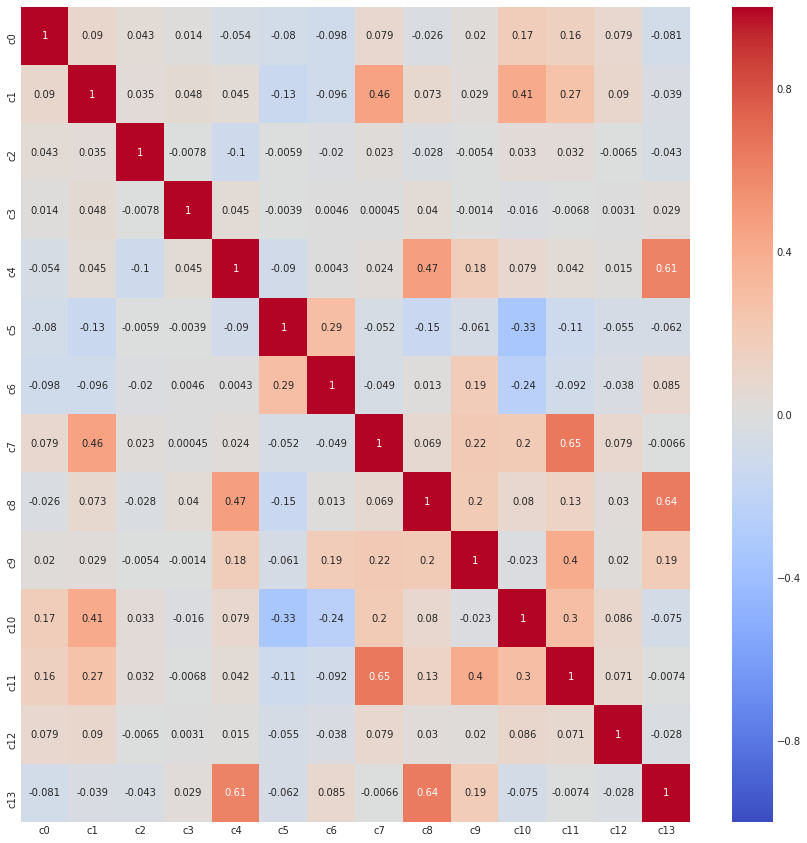

In [25]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

## Logistic Regression Implementation

## Formulation
> The output for a binary classification logistic regression is either 0 or 1. 
Since we are building a linear model.
$$  Z = WX +B \\
h(\theta) = sigmoid(Z)
$$

We define the sigmoid function as:
$$ sig(t) = \frac{1}{(1+e^{-t})}
$$

The output for $h(\theta)$ is the estimated probability of the predicted value is the actual value.

In [29]:
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    def sigmoid_activation(result):
        final_result = 1/(1+np.exp(-result))
        return final_result
    
    ################## YOUR CODE HERE ################# 
    grad = None
    new_model = None
    w_bc = sc.broadcast(W)
    grad = augmentedData.map(lambda x: (sigmoid_activation(np.dot(w_bc.value, x[0]))- x[1])) \
                        .mean()
    
    new_model = list(np.array(W) - learningRate*grad)
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [113]:
# part d - write function to compute loss (FILL IN MISSING CODE BELOW)
def LogitLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    # Helper function
    def sigmoid_activation(result):
        final_result = 1/(1+np.exp(-result))
        return final_result
    
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    gradData = augmentedData.sample(False,0.05,2019)
   
    w_bc = sc.broadcast(W)
    
    loss = gradData.map(lambda x: ((x[1]*np.log(sigmoid_activation(np.dot(w_bc.value, x[0])))) 
                                   + ((1-x[1])*(sigmoid_activation(np.log(1-np.dot(w_bc.value, x[0]))))))).mean()
    return loss

In [21]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model, 0.1)
        training_loss = LogitLoss(trainRDD, model) 
        test_loss = LogitLoss(testRDD, model) 
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [111]:
smallRDD_stg = sc.textFile('data/train_small.txt').map(lambda x: list(x.split('\t'))).map(lambda x: ['0' if i == '' else i for i in x])
#('1' if i == ''  else x for i in x))
smallRDD = smallRDD_stg.map(lambda x: (x[1:14],x[0])).map(lambda x: ([int(i) for i in x[0]],int(x[1])))
print(smallRDD.take(1))
BASELINE = list(np.zeros((14), dtype = int))
BASELINE[0] = 1



[([1, 1, 5, 0, 1382, 4, 15, 2, 181, 1, 2, 0, 2], 0)]


In [115]:
wInit = BASELINE
trainRDD, testRDD = smallRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
logerr_train, logerr_test, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 5, True)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

SyntaxError: positional argument follows keyword argument (<ipython-input-115-7e08db8eed0c>, line 4)